<b>Author: Christian Camilo Urcuqui López

Date: 6 december 2018

</b>

<img src="../../PyTorch/assets/conv_net.jpg" width="700" />


# Convolutional Neural Networks 

They are important neural network architecture to resolve problems related with data with more 2D, for example image processing. 

One important thing to make is to normalize each image, because it helps these gradient calculations stay consistent, for example if we have a resolution of 255 we must divide each pixel to this number and we will have a number between zero to one.

Once we have the data normalized the idea is to apply a flattening process (in other words to change the shape or reshape) 

Let's remember the NMIST dataset of handwritten digits, you can see more information in it's 
<a href='../../Deep Learning/notMNIST.ipynb'>Link</a>

+ [NMIST](#NMIST)
+ [Framework on CNN](#Framework-on-CNN)
+ [Convolutional Neural Layer](#Convolutional-Neural-Layer)
    + [Filters](#Filters)
    + [Pooling layer](#Pooling-layer)
+ [CNN on Pytorch](#CNN-on-Pytorch)
+ [References](#References)


## NMIST

In [7]:
from IPython.display import display, Image
from torchvision import datasets, transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # TODO: compose transforms here
dataset = datasets.MNIST('../../../Datasets/MNIST_data/', download=True, transform=transform)

In [23]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../../../Datasets/MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

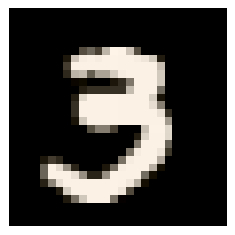

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True) # TODO: use the ImageFolder
images, labels = next(iter(dataloader))
imshow(images[0], normalize=True)

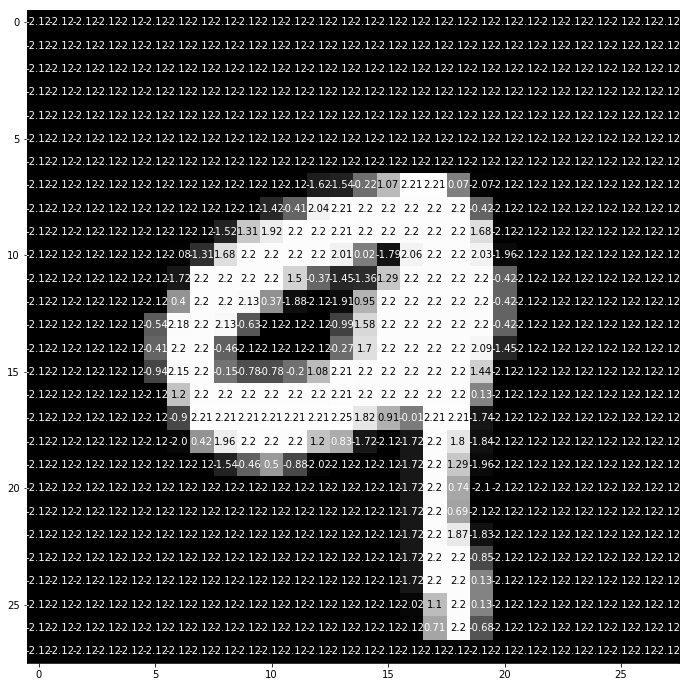

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

images = images.numpy()

img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

As you can see we have a image composed by gray pixels, so the next idea is to flatten them.

In [25]:
images = torch.from_numpy(images)
images[0].shape

torch.Size([1, 28, 28])

In [26]:
new_img = images[0].view(1,784)
new_img.shape

torch.Size([1, 784])

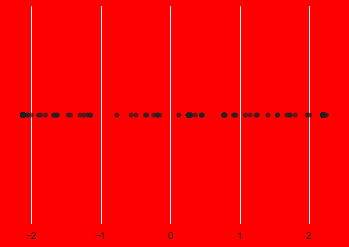

In [66]:
import seaborn as sns

image = new_img.numpy().transpose()
sns.set(rc={'axes.facecolor':'red', 'figure.facecolor':'red'})
sns.stripplot(image, palette=sns.dark_palette((260, 75, 60), input="husl"), alpha=0.7)


Through the flattening process, we got a vector composed by the gray pixels, each of them is going to be an input for a neural network, and the aim of the model is to discover the pattern behind the training data

In [4]:
num_workers = 0 # if you want to load data in parallel
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) # TODO: compose transforms here
train_data = datasets.MNIST('../../../Datasets/MNIST_data/', download=True, transform=transform, train=True)
test_data = datasets.MNIST('../../../Datasets/MNIST_data/', download=True, transform=transform, train=False)

# obtain training indices that will be used for validation 
num_train = len(train_data)
indices = list(range(num_train))
np.random.seed(7)
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx =  indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler =train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler= valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers=num_workers)

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 392) 
        self.fc3 = nn.Linear(392, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activatiojn function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        x = F.log_softmax(self.fc3(x), dim=1)
        return x    

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [20]:
model = Network()
model.to(device)
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print_every = 5
# number of epochs to train the model
n_epochs = 50
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity


for e in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    running_loss = 0
    model.train() # prep model for training
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels =  images.to(device), labels.to(device)        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
       
    ######################    
    # validate the model #
    ######################  
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        data, target =  data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.383120 	Validation Loss: 0.052495
Validation loss decreased (inf --> 0.052495).  Saving model ...
Epoch: 2 	Training Loss: 0.185646 	Validation Loss: 0.036630
Validation loss decreased (0.052495 --> 0.036630).  Saving model ...
Epoch: 3 	Training Loss: 0.136148 	Validation Loss: 0.029274
Validation loss decreased (0.036630 --> 0.029274).  Saving model ...
Epoch: 4 	Training Loss: 0.111077 	Validation Loss: 0.025398
Validation loss decreased (0.029274 --> 0.025398).  Saving model ...
Epoch: 5 	Training Loss: 0.095940 	Validation Loss: 0.021952
Validation loss decreased (0.025398 --> 0.021952).  Saving model ...
Epoch: 6 	Training Loss: 0.080429 	Validation Loss: 0.020622
Validation loss decreased (0.021952 --> 0.020622).  Saving model ...
Epoch: 7 	Training Loss: 0.072261 	Validation Loss: 0.022593
Epoch: 8 	Training Loss: 0.064921 	Validation Loss: 0.018561
Validation loss decreased (0.020622 --> 0.018561).  Saving model ...
Epoch: 9 	Training Loss: 0.059224 

### Load the Model with the Lowest Validation Loss

In [21]:
model.load_state_dict(torch.load('model.pt'))

In [22]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    
    data, target =  data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.064224

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (992/1010)
Test Accuracy of     4: 98% (968/982)
Test Accuracy of     5: 96% (864/892)
Test Accuracy of     6: 98% (945/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 96% (977/1009)

Test Accuracy (Overall): 98% (9812/10000)


tensor([-0.0000, -0.0000, -0.0002, -0.0000, -0.0001, -0.0001, -0.0000, -0.0010,
        -0.0296, -0.0000,  0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0010,
        -0.0001, -0.0000, -0.0005,  0.0000], grad_fn=<MaxBackward0>)

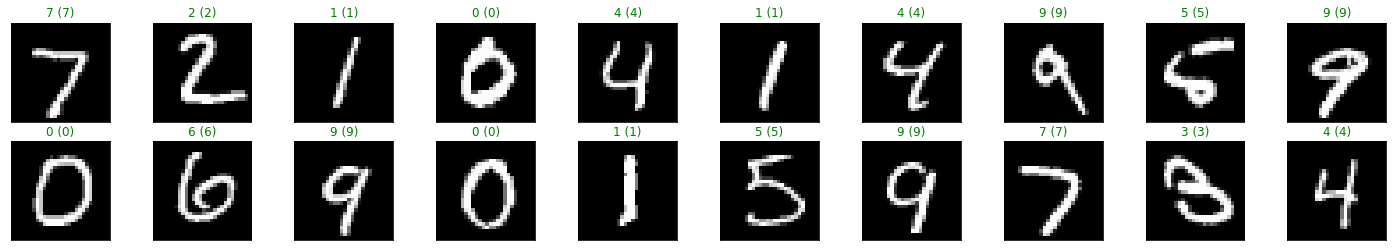

In [23]:
# the next code gets one batch of test images
detaiter = iter(test_loader)
model.eval()
model.to('cpu')
images, labels =  detaiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

#plot the images in the batch, along with predicted and true labels
fig =  plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

_

## Framework on CNN

We could define the next steps in order to evaluate different models to image image classification.

+ __Visualize Data__
+ __Pre-Process__. _Normalize Transform_
+ __Define a Model__. _Do your Research!_
+ __Train your model__. _Define loss & optimization functions_
+ __Save the Best Model__. _Consider using a validation dataset_
+ __Test your model__

## Convolutional Neural Layer

As we saw, a MLP is a good architecture with a good accuracy to resolve a problem related with a dataset like NMIST, but, this data doesn't have a lot of noice, for example all the digits are in the center of the picture and doesn't have any color, these characteristics can't be a problem for a MLP. 

CNN appears to resolve the problems mentioned becuase it allows us to analyze groups of pixels at a time and keep this information in something called the convolutional layer, this layer applies different filters also known as convolutional kernels to an input image, the filters may have extracted features like the edges of the object in the image or the colors.

One important difference between MLP and CNN is that each node on MLP's hidden layer is connected with their antecedents, instead, CNN are locally connected where their nodes are only connected to only a small subset of the previous layer's nodes.

### Filters 

When we are talking about patterns in a image we can ralate them with color or shape. 

Shape can also be thought of as patterns of a intensity in an image. With this idea in head we can talk about _frequency_, frequency in images is a __rate of change__. High frequency is related where the intensity changes a lot, and a low frequency image may be one that is relatively uniform in brithness or changes very slowly. 

High-frequency components are related with the edges of objects in images.

Filters are used to filter out unwanted or irrelevant information in an image or to amplify features 
+ High-pass filters
    + Sharpen an image
    + Enchance high-frequency parts of an image
    
Edges are areas in an image where the intensity changes very quickly, and they often indicate object boundaries

### Convolution Kernels

A kernel is a matrix of number that modifies an image, where the sum of all values is _zero_, and this is important because the idea is to compute the difference or change between neighboring pixels.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4c694c500c1394918e437d9259fd10d8df3d9372/2-Figure2-1.png" width="700" />

So the idea is to apply to the function of an image $F(x,y)$ a convolution operation __*__.

$K*F(x,y)=$output image

The convolution operation represents who the filter pass behind the picture.


<img src="https://developer.apple.com/library/archive/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg" width="400" />

Perhaps the solution is interesting we must pay attention to one issue and this is what do you do if there are no surroinding pixels like on an image corner or edge?, in order to resolve this question we can apply three things:
+ __Extend__ the nearest border pixels are conceptually extended as far as neccesary to provide values for the convolution. 
+ __Padding__ The image is paddded with a border of 0's, black pixels
+ __Crop__  Any pixel in the output image which would requiere values from beyond the edge is skipped. 

The convolutional layer is produced by applying series of many different image filters, also known as convolutional kernels, to an input image.

<img src="notebook_ims/conv_layer.gif" width="800" />

We can see the application of the filters on a CNN in the next <a href='conv_visualization.ipynb'>Notebook</a>


### Stride & Padding 

Basically, _stride_ is the movement that each filter does in an image, and _padding_ is the way to add pixels (0's) around the borders in order to complete the convolutional process of each pixel. 

### Pooling layer

<img src='notebook_ims/CNN_all_layers.png' height=50% width=50% />

Pooling layers take convolutional layer as input in order to reduce the dimensionality, we can find different types:
+ ___Max pooling layer___, it itakes a stack of feature maps as input and calculates the maximum of the pixels contained in the window
+ ___Average pooling___, it chooses to average pixel values in a given window. This kind of pooling is typically not used for image classifcation problems because maxpooling is better at noticing the most important details about edges and other features in an image, but this is used in applications which smoothing an image is prefarable.


<img src='notebook_ims/maxpooling_ex.png' height=50% width=50% />
We can see the application of maxpooling in the next <a href='maxpooling_visualization.ipynb'>Notebook</a>

<img src='https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif' height=50% width=50% />

3x3 convolution with strides of 1


### Formula: Number of Parameters in a Convolutional Layer

We will have three parameters in a convolutional layer, these are `filters/out_channels`, `kernel_size`, and `input_shape`. Let's define the next variables:
+ `K` - The number of filter in the convolutional layer.
+ `F` - The height and width of the convolutional filters
+ `D_in` - The depth of the previous layer

`k` = `out_channels`, and `F` =  `kernel_size`, `D_in` is the last value in the `input_shape` tuple, usually 1 or 3 (RGB and grayscale, respectively).

The total number of weights in the convolutional layer is `K*F*F*D_in`. We must add the bias termn per filter, so the convolutional layer has `k` biases, then, the _number of parameters_ in the convolutional layer is given by `K*F*F*D_in + K`

## CNN on Pytorch

We can define a convolutional layer in Pytorch through the next method and it's parameters.

```
self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
example:
self.conv1 = nn.Conv2d(3, 16, kernel_size, stride=1, padding=0)

```

For the last case, 3 is the depth of the input image and 16 is the depth of the convolutional layer, in other words, it is the number of __layers__ , the kernel size means the size of the filters that define a convolutional layer, for example, if we put 3 then we will have a filter of 3x3, stride and padding have default values, but should be set depending on how large you want your output to be in the spatial dimensions x, y

The mext method allows us to define a _maxpooling layer_

```
nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

```

In [1]:
# imoprt the Pytorch package
import torch.nn as nn

In [ ]:
def __init__(self):
        super(ModelName, self).__init__()
        self.features = nn.Sequential(
              nn.Conv2d(1, 16, 2, stride=2),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True),

              nn.Conv2d(16, 32, 3, padding=1),
              nn.MaxPool2d(2, 2),
              nn.ReLU(True) 
         )

## References 

+ Convolutional Neural Networks. Udacity
+ https://iamaaditya.github.io/2016/03/one-by-one-convolution/